In [22]:
%%html
<script
src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.7/require.min.js"
integrity="sha512-J5ha2LF4Le+PBQnI5+xAVJDR+sZG9uSgroy4n/A6TLjNkvYQbqZA8WHZdaOvJ0HiKkBC9Frmvs10rFDSHKmveQ=="
crossorigin="anonymous"
referrerpolicy="no-referrer"></script>

In [23]:
import plotly.io as pio
pio.renderers.default = "notebook_connected+plotly_mimetype"

Large genomic datasets like the [vector observatory](https://malariagen.net/vobs) can be difficult to analyse. To make analysing these data easier, we created [analytical software](https://malariagen.github.io/malariagen-data-python/latest/) and an [online training course](https://anopheles-genomic-surveillance.github.io/), and these have definitely helped a lot. But many potential users of these data are coming from an entomology background without much experience of either genomics or programming, and so coming up with the right code can still be a challenge. AI coding assistants are getting very good. Would it be possible to create a specialised AI assistant to support generation of code to analyse genomic data on malaria mosquitoes?

# Use case: investigating insecticide resistance

Consider a use case where an analyst would like to investigate evidence for insecticide resistance in mosquito populations within a country of interest. Assume the analyst has good knowledge of vector biology but patchy knowledge of genomics and the molecular biology of insecticide resistance. Assume the analyst has completed [basic training in vector genomics data analysis](https://anopheles-genomic-surveillance.github.io/) but is not an experienced programmer and finds writing data analysis code challenging.

The analyst might start with a relatively broad question like, "Is there resistance to pyrethroid insecticides in Uganda?" But there are multiple possible mechanisms of pyrethroid resistance that need to be considered, and there are also multiple species of malaria vector present in Uganda. So this question is likely to need some refinement. If I were assisting this user, I would ask a series of questions to narrow down the focus, and to help the user become aware of the relevant data that are available. I would then be able to identify a smaller set of analysis function calls and parameter values that are relevant. 

Would it be possible to create a chatbot assistant to help with this refinement? E.g., here is a hypothetical conversation between a user and an assistant that would refine the scope of the initial question to reach a point where code generation would be easier:

<table style="width: 100%; font-size: 1.1em; font-style: italic;">
    <colgroup>
       <col span="1" style="width: 50%;">
       <col span="1" style="width: 50%;">
    </colgroup>
    <thead>
        <tr>
            <th style="text-align: left;">User</th>
            <th style="text-align: left;">Assistant</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>
<p>Is there resistance to pyrethroid insecticides in Uganda?</p> 
            </td>
            <td></td>
        </tr>
        <tr>
            <td></td>
            <td>
<p>Which mosquito species are you interested in?</p>
<p>In Uganda there are data available for <em>Anopheles gambiae</em>, <em>Anopheles arabiensis</em> and <em>Anopheles funestus</em>.</p>
            </td>
        </tr>
        <tr>
            <td>
<p>Anopheles gambiae.</p>
            </td>
            <td></td>            
        </tr>
        <tr>
            <td></td>
            <td>
<p>Which molecular mechanism of pyrethroid resistance are you interested in?</p>
<p>E.g., target-site resistance, Cyp-mediated metabolic resistance, or other resistance mechanisms?</p>
            </td>            
        </tr>
        <tr>
            <td>
<p>Cyp-mediated metabolic resistance.</p>
            </td>
            <td></td>            
        </tr>
    </tbody>
</table>


At this point, we probably have just enough information to start suggesting some code. E.g., we know that copy number amplification of *Cyp* genes has been associated with pyrethroid resistance. I might suggest to try analysing CNV frequencies at a selection of *Cyp* genes which have been previously linked to pyrethroid resistance. Here is some code which sets up an API to access data on the *Anopheles gambiae* complex, then uses two function calls to compute and then visualise gene CNV frequencies in Uganda, grouping mosquitoes by year and level one administrative units.

In [12]:
# Set up the API to access data from the Anopheles gambiae complex.
import malariagen_data
ag3 = malariagen_data.Ag3()

In [13]:
# Define genes of interest.
interesting_cyp_genes = [
    "AGAP002862",  # Cyp6aa1
    "AGAP013128",  # Cyp6aa2
    "AGAP002865",  # Cyp6p3
    "AGAP000818",  # Cyp9k1
    "AGAP008212",  # Cyp6m2
    "AGAP008218",  # Cyp6z2    
]

In [15]:
# Compute gene CNV frequencies.
df_cyp_cnv_frq = ag3.gene_cnv_frequencies(
    region=interesting_cyp_genes,
    sample_query="country == 'Uganda' and taxon == 'gambiae'",
    cohorts="admin1_year",
)

Load CNV HMM data:   0%|          | 0/1360 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/2 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/1360 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/2 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/1360 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/2 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/680 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/1 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/1020 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/1 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/1020 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/1 [00:00<?, ?it/s]

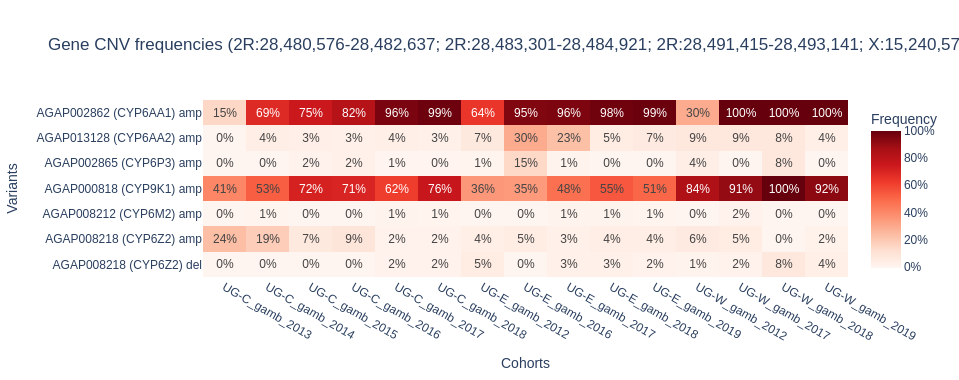

In [24]:
# Visualise CNV frequencies as a heatmap.
ag3.plot_frequencies_heatmap(df_cyp_cnv_frq)

This is a useful output, because we can see for example that amplifications of *Cyp6aa1* and *Cyp69k1* are very high or fixed in almost all regions and years. Both of these genes are associated with pyrethroid resistance, and so this combination implies very strong metabolic resistance. 

For Uganda there are data for multiple years and regions, and the user might also be interested in changes over time. I might therefore be tempted to suggest some code to visualise frequency time series, e.g.:

In [17]:
# Compute gene CNV frequencies.
ds_cyp_cnv_frq = ag3.gene_cnv_frequencies_advanced(
    region=interesting_cyp_genes,
    sample_query="country == 'Uganda' and taxon == 'gambiae'",
    area_by="admin1_iso",
    period_by="year",
)

Load CNV HMM data:   0%|          | 0/1360 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/2 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/1360 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/2 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/1360 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/2 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/680 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/1 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/1020 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/1 [00:00<?, ?it/s]

Load CNV HMM data:   0%|          | 0/1020 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/1 [00:00<?, ?it/s]

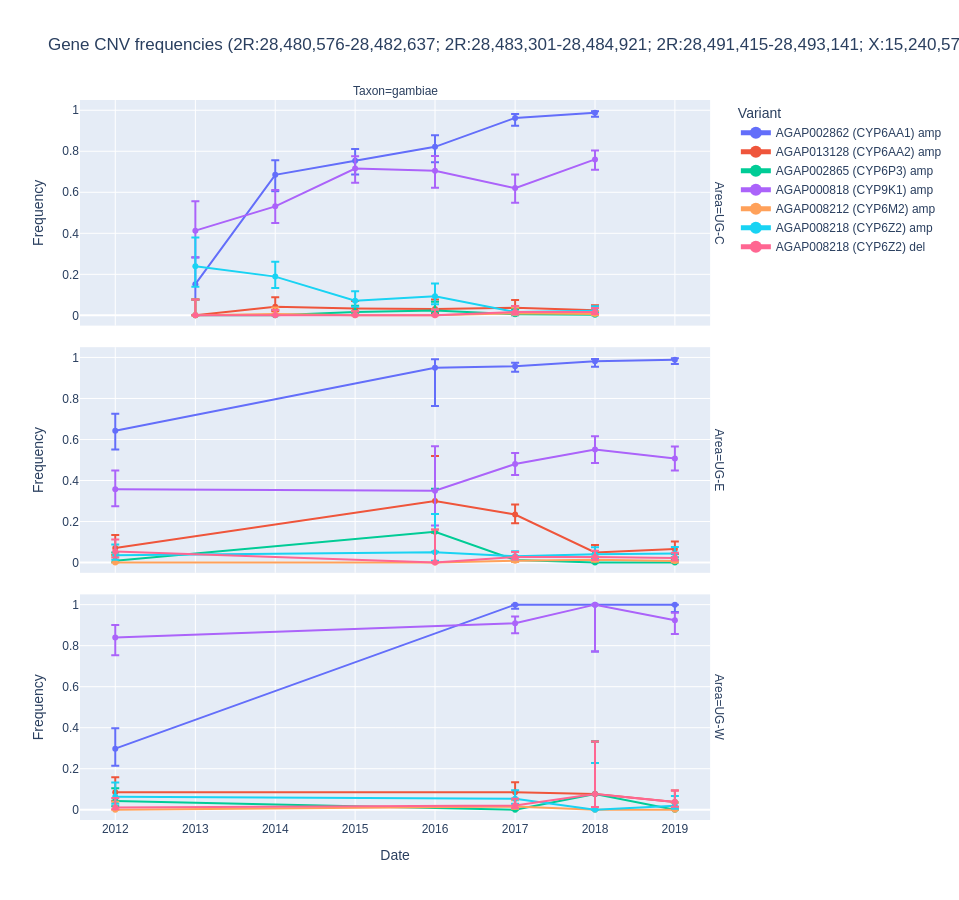

In [25]:
# Plot frequency time series.
ag3.plot_frequencies_time_series(
    ds_cyp_cnv_frq,
    height=900,  # need enough height for three sub-plots
)

These time series give us some more information, e.g., they show that frequencies of *Cyp6aa1* and *Cyp9k1* have generally increased after 2012, although there are some geographical differences between the three regions of Uganda for which we have data.

This is definitely getting us somewhere, but it's worth mentioning that there are a lot of variations and other analyses we might suggest, as well as some subtleties.

E.g., if we wanted to analyse *Anopheles funestus* instead of *Anopheles gambiae*, we would need to provide a different set of gene identifiers for the interesting *Cyp* genes to include.

Also, there are in fact 107 cytochrome P450 (*Cyp*) genes in the *Anopheles gambiae* genome in total, and although only some of these have been associated with resistance previously, it's possible that prior knowledge is incomplete. Should we analyse all 107 genes, or just the smaller set of validated genes? Furthermore, some studies are also starting to find SNPs in *Cyp* genes are markers of resistance. Should we analyse SNPs as well as CNVs? These are tricky decisions, because we could come up some analysis code that is perfectly sensible from a biological point of view, but would overwhelm the user with data. E.g., there are often dozens of SNPs within each *Cyp* gene, even after filtering out low frequency variants, and 107 genes each with dozens of SNPs is hard to visualise.

Anyway, hopefully this is a useful example to start thinking about what sort of coding assistant would be useful, and how it could be implemented.